In [1]:
import genjax
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from genjax import grasp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
key = jax.random.PRNGKey(314159)

In [2]:
grasp

<module 'genjax.grasp' from '/home/femtomc/Research/genjax/src/genjax/grasp.py'>

## Model

In [3]:
@genjax.gen
def model():
    x = grasp.normal_reparam(0.0, 10.0) @ "x"
    y = grasp.normal_reparam(0.0, 10.0) @ "y"
    rs = x**2 + y**2
    z = grasp.normal_reparam(rs, 0.1 + (rs / 100.0)) @ "z"

In [4]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
tr = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))(sub_keys, ())
chm = tr.strip()

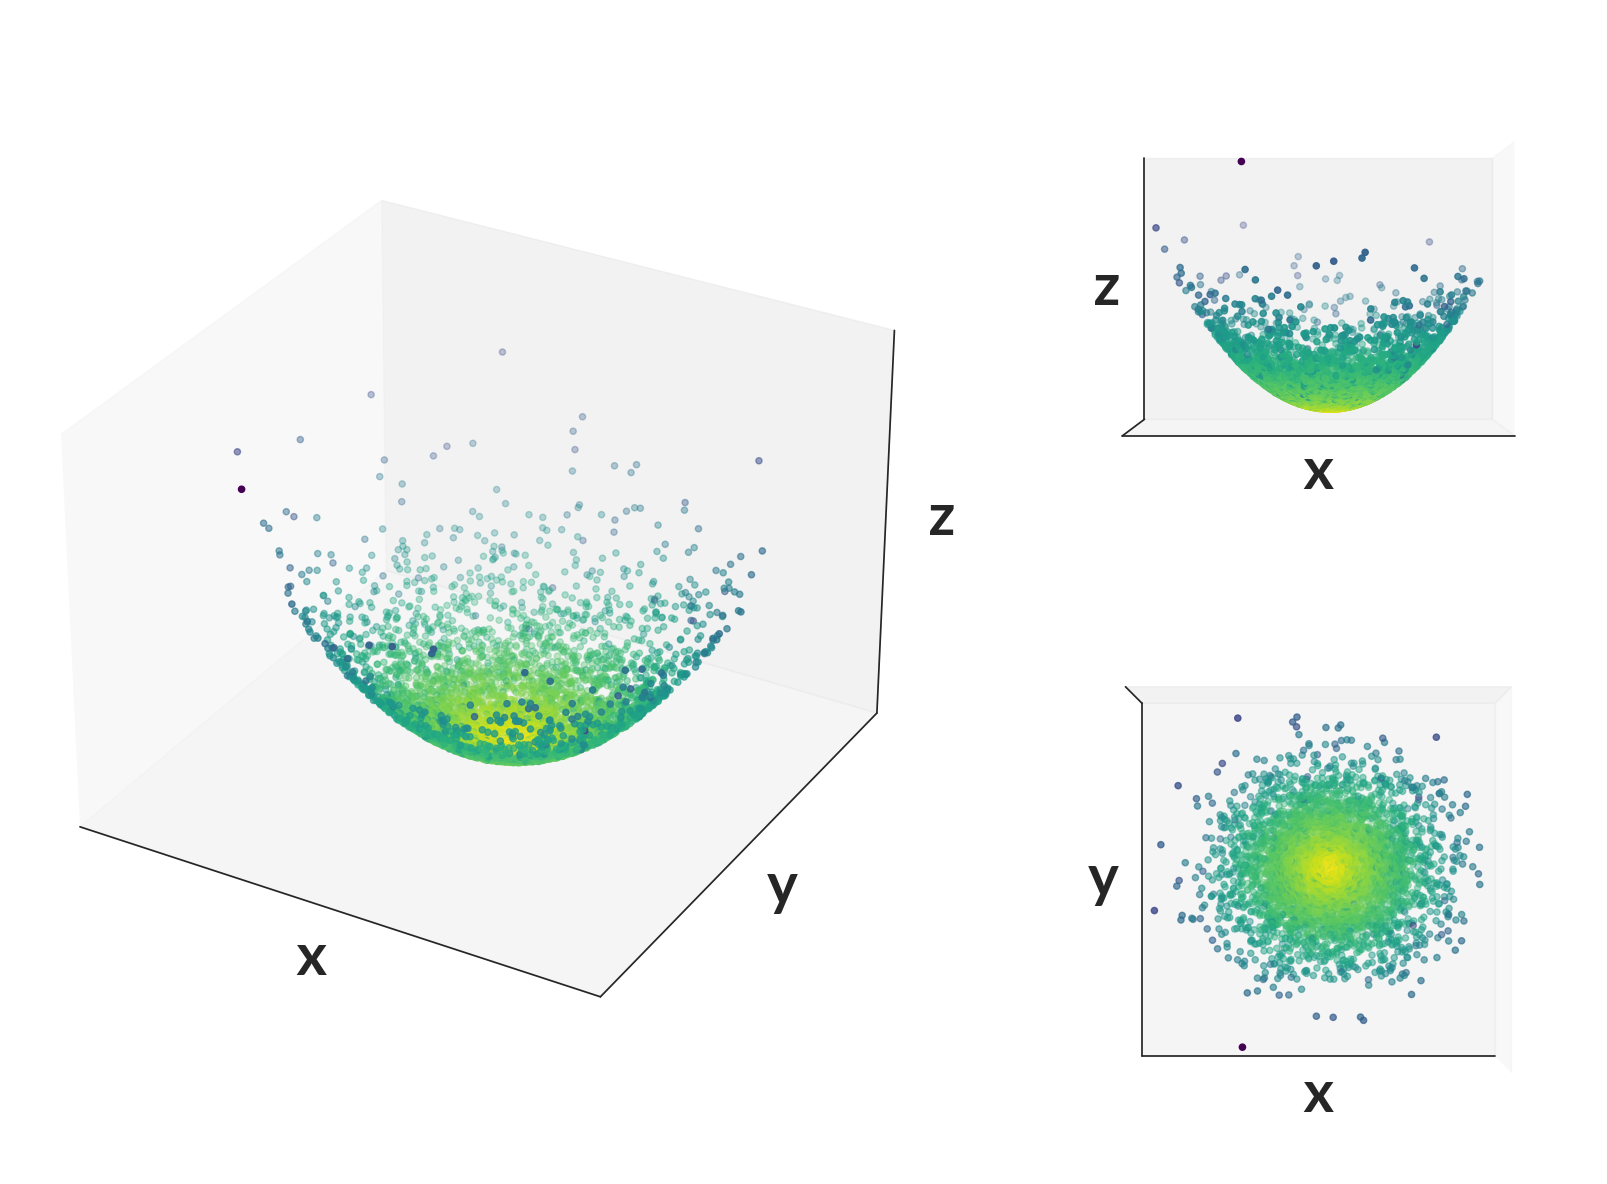

In [5]:
x, y, z = chm["x"], chm["y"], chm["z"]
scores = tr.get_score()

# Create a new figure
fig = plt.figure(figsize=(18, 12))  # Adjust the size for better visualization

gs = GridSpec(2, 2, height_ratios=[1, 1])
label_fontsize = 42  # Set the desired font size here

# First subplot - Original 3D plot
ax1 = fig.add_subplot(gs[:, 0], projection="3d")  # This spans both columns
ax1.scatter(x, y, z, c=scores, cmap="viridis")
ax1.set_xlabel("x", fontsize=label_fontsize)
ax1.set_ylabel("y", fontsize=label_fontsize)
ax1.set_zlabel("z", fontsize=label_fontsize)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

# Second subplot - Rotated 3D plot looking at the XZ plane
ax2 = fig.add_subplot(gs[0, 1], projection="3d")
ax2.scatter(x, y, z, c=scores, cmap="viridis")
ax2.set_xlabel("x", fontsize=label_fontsize)
ax2.set_zlabel("z", fontsize=label_fontsize)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.view_init(elev=0, azim=-90)

# Third subplot - Rotated 3D plot looking at the XZ plane
ax3 = fig.add_subplot(gs[1, 1], projection="3d")
ax3.scatter(x, y, z, c=scores, cmap="viridis")
ax3.set_xlabel("x", fontsize=label_fontsize)
ax3.set_ylabel("y", fontsize=label_fontsize)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_zticks([])
ax3.view_init(elev=90, azim=-90)


# Show the plots
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

# Save the figure as an SVG file (optional)
fig.savefig("img/model_prior.svg", format="svg")

plt.show()

## Naive variational guide

In [6]:
# Now, we define our variational proposal.
@genjax.gen
def variational_family(data, ϕ):
    μ1, μ2, log_σ1, log_σ2 = ϕ
    x = grasp.normal_reparam(μ1, jnp.exp(log_σ1)) @ "x"
    y = grasp.normal_reparam(μ2, jnp.exp(log_σ2)) @ "y"

In [7]:
data = genjax.choice_map({"z": 5.0})
objective = grasp.elbo(model, variational_family, data)

In [8]:
# Training.
key = jax.random.PRNGKey(314159)
ϕ = (0.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(objective.value_and_grad_estimate, in_axes=(0, None)))
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
print(ϕ)

-825.4226
-7.987867
-8.034029
-8.206104
-7.992387
-7.880024
-7.936195
-8.985643
-8.162853
-7.8599386
-8.0959015
-8.141094
-8.150928
-8.17004
-8.10012
-8.124427
-8.051115
-8.067102
-8.014355
-7.9789457
(Array(0.00035516, dtype=float32), Array(-2.2183301, dtype=float32), Array(-1.2732011, dtype=float32), Array(-3.3843782, dtype=float32))


### Sampling from the trained variational family

In [9]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 50000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(
    sub_keys, (data, ϕ)
)
chm = tr.strip()

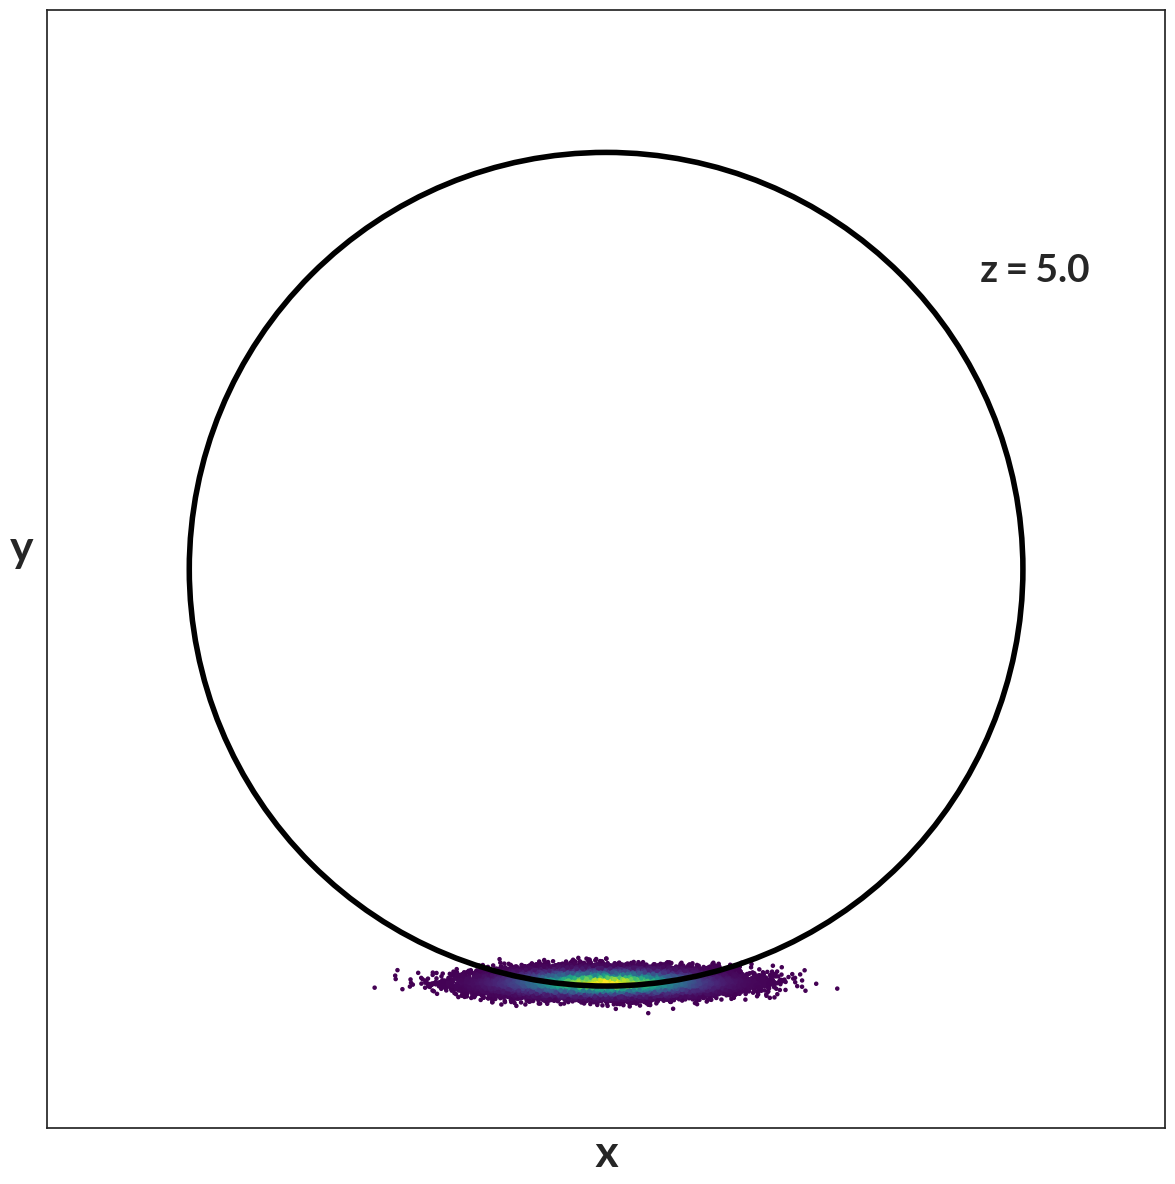

In [10]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())

fig, ax = plt.subplots(figsize=(12, 12))
label_fontsize = 32  # Set the desired font size here

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, c=scores, cmap="viridis", marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)

ax.text(2.3, 1.6, "z = 5.0", ha="center", va="center", fontsize=28)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/naive_variational_elbo_samples.svg", format="svg")

# Show the plot
plt.show()

## Training with IWAE

$$\text{IWAE ELBO} = E_{\{z_k\}_{k = 0}^N \sim Q}[\log \frac{1}{N}\sum_i w_i(z_i)]$$

where $w_i(z_i) = \frac{P(z_i, x)}{Q(z_i)}$

In [11]:
data = genjax.choice_map({"z": 5.0})
iwae_objective = grasp.iwae_elbo(model, variational_family, data, 5)

In [12]:
# Training with IWAE.
key = jax.random.PRNGKey(314159)
ϕ = (3.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(iwae_objective.value_and_grad_estimate, in_axes=(0, None)))
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
print(ϕ)

-298.38464
-7.447097
-7.4370546
-7.441834
-8.046443
-7.5010815
-7.6765738
-7.430034
-7.5251913
-7.300045
-7.4467244
-7.5626388
-7.5281997
-7.317253
-7.452917
-7.63071
-7.7050753
-7.703191
-7.4743013
-7.441646
(Array(2.1577833, dtype=float32), Array(0.01487101, dtype=float32), Array(-2.6079545, dtype=float32), Array(-0.5783876, dtype=float32))


In [13]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 50000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(
    sub_keys, (data, ϕ)
)
chm = tr.strip()

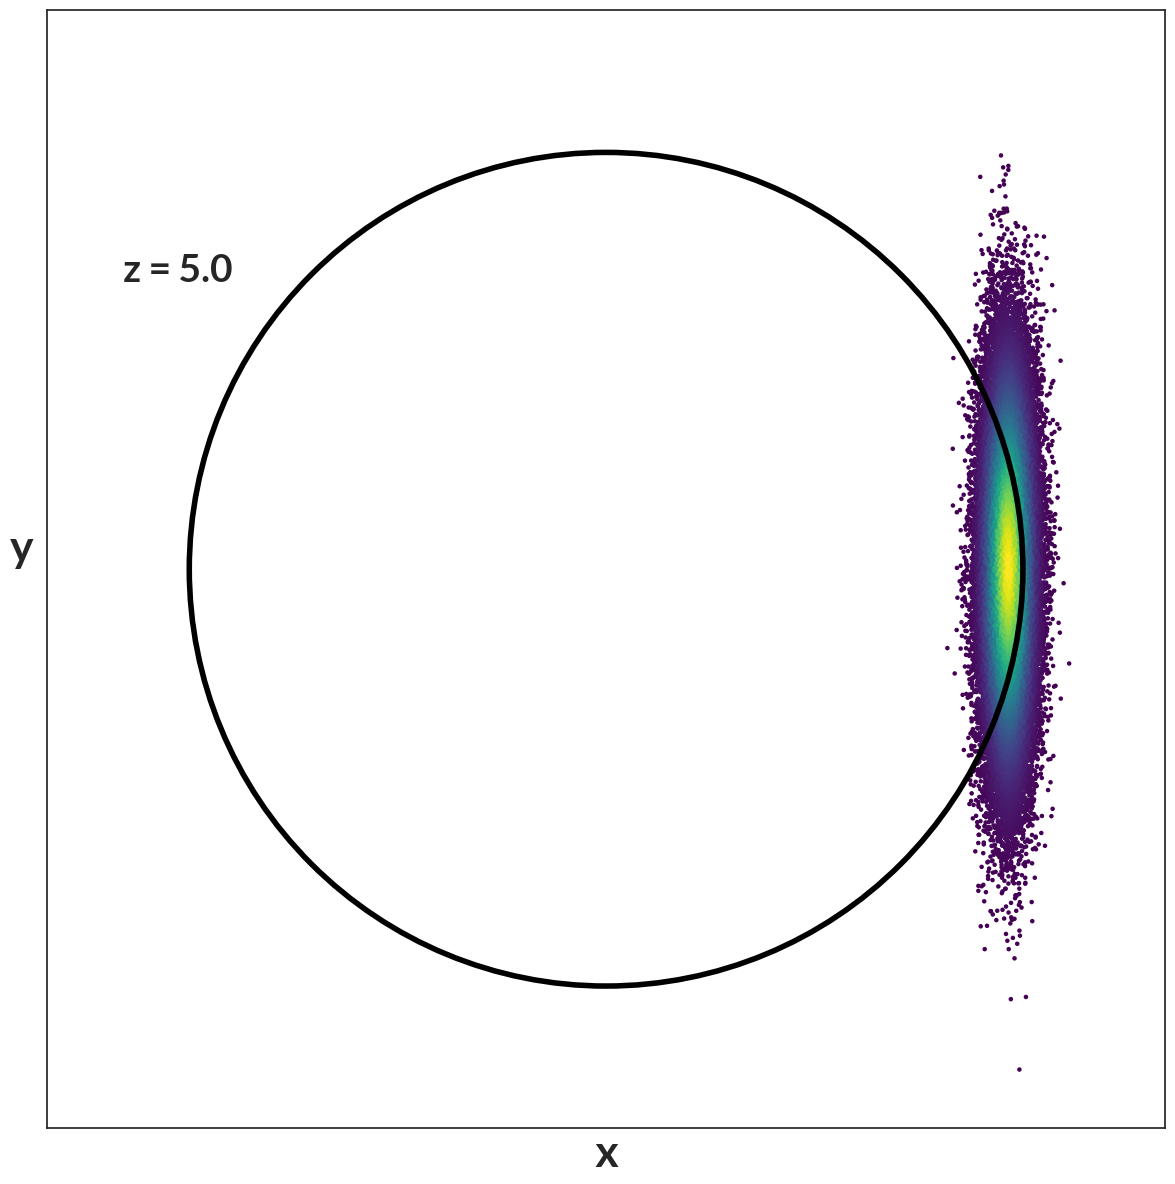

In [14]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())

fig, ax = plt.subplots(figsize=(12, 12))
label_fontsize = 32  # Set the desired font size here

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, c=scores, cmap="viridis", marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)

ax.text(-2.3, 1.6, "z = 5.0", ha="center", va="center", fontsize=28)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/naive_variational_iwae_elbo_5_samples.svg", format="svg")


# Show the plot
plt.show()

In [15]:
iwae_objective = grasp.iwae_elbo(
    model, variational_family, genjax.choice_map({"z": 5.0}), 20
)

In [16]:
# Training with IWAE.
key = jax.random.PRNGKey(314159)
ϕ = (3.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(iwae_objective.value_and_grad_estimate, in_axes=(0, None)))
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
print(ϕ)

-26.630377
-6.9312296
-6.710473
-7.042858
-6.96737
-6.6490364
-6.829247
-7.160947
-6.706791
-6.903194
-7.1345034
-6.8049173
-6.9012794
-6.7741156
-6.9928775
-6.9813623
-7.1512036
-6.9707975
-7.017972
-7.016147
(Array(1.9783885, dtype=float32), Array(-0.04923397, dtype=float32), Array(-1.3319206, dtype=float32), Array(0.04076543, dtype=float32))


In [17]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 50000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(
    sub_keys, (data, ϕ)
)
chm = tr.strip()

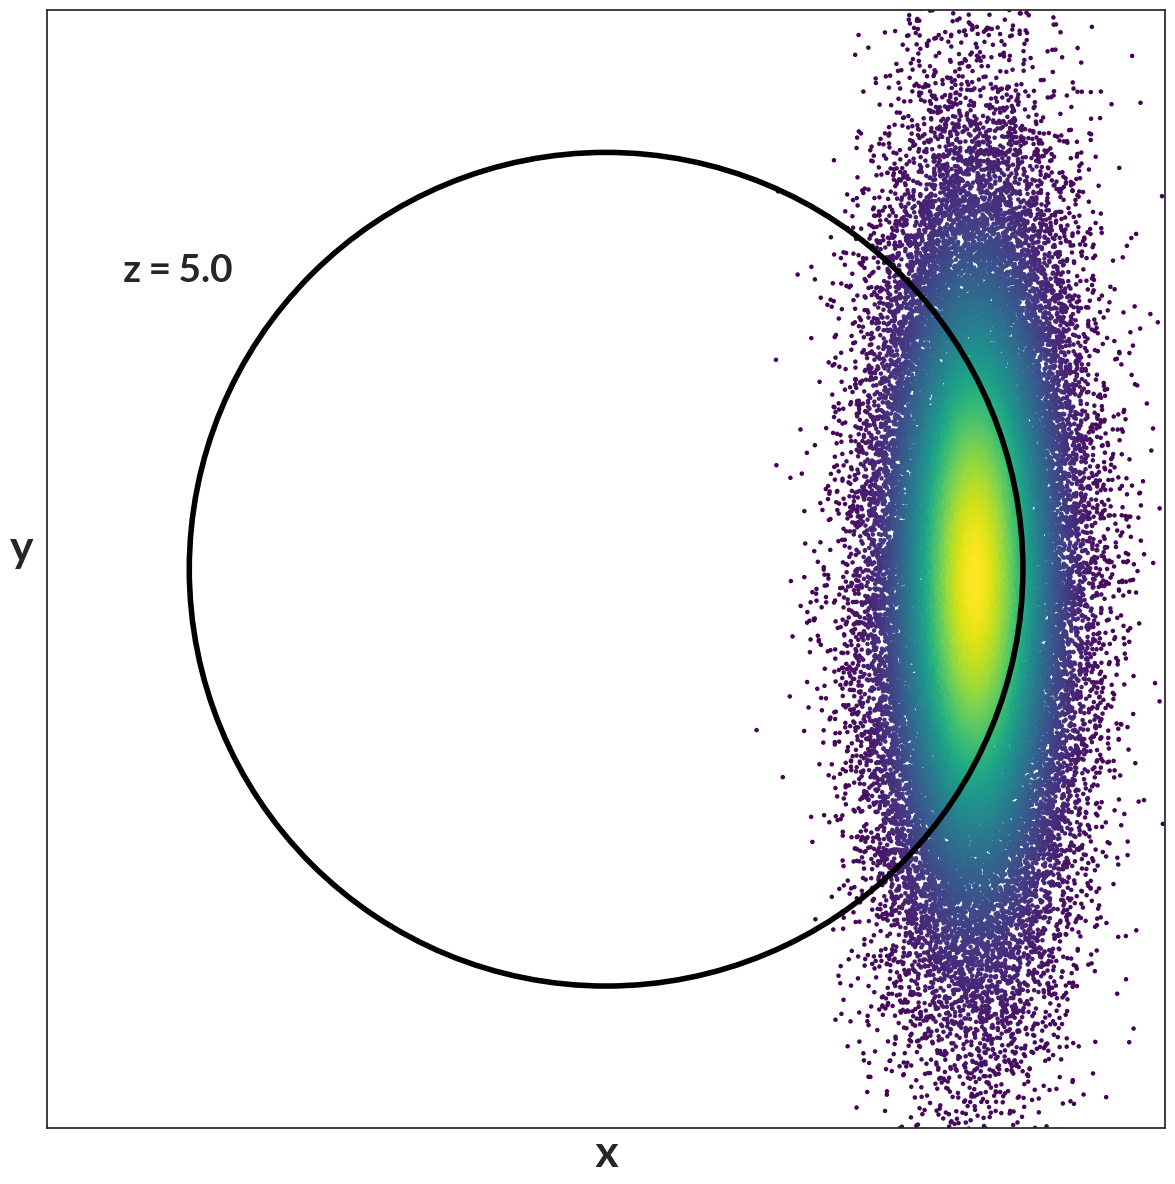

In [18]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())

fig, ax = plt.subplots(figsize=(12, 12))
label_fontsize = 32  # Set the desired font size here

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, c=scores, cmap="viridis", marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)

ax.text(-2.3, 1.6, "z = 5.0", ha="center", va="center", fontsize=28)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/naive_variational_iwae_elbo_20_samples.svg", format="svg")

# Show the plot
plt.show()